<h1><center> ML DSL in Action </center></h1>

Amazon AWS: 
1. Amazon EMR
2. Amazon S3
3. Amazon SageMaker

In [1]:
import logging
import boto3
from botocore.exceptions import ClientError
import os
import numpy as np

import com.griddynamics.dsl.ml.mldsl as mldsl
from com.griddynamics.dsl.ml.mldsl import job_tracker
from com.griddynamics.dsl.ml.settings.profiles import SageMakerProfile, Profile
from com.griddynamics.dsl.ml.settings.description import Platform

# ML Model to Predict Positive or Negative Review

In [2]:
#Set some env variables to run script locally
os.environ['SM_MODEL_DIR'] = 'demo/model/'
os.environ['SM_CHANNEL_TRAINING'] = 'demo/data/'

#### LSTM Train Script

In [3]:
%%py_script -e --name pytorch_model.py --path demo/scripts --epochs 3
# %py_load scripts/pytorch_model.py
#!/usr/bin/python
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import itertools
import os
import argparse
import json
from shutil import copy2
import boto3
import io


def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index)
    emb_dim = word_to_vec_map.item().get("apple").shape[0]
    emb_matrix = np.zeros((vocab_len, emb_dim))
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = np.float32(word_to_vec_map.item().get(word))
    return emb_matrix


def accuracy(a, b):
    a = torch.argmax(a, dim=1)
    b = torch.argmax(b, dim=1)
    return torch.sum(torch.eq(a, b)).float() / list(a.size())[0]


class LSTMModel(nn.Module):
    # predict steps is output_dim lstm_size is hidden dim of LSTM cell
    def __init__(self, word_to_vec_map, word_to_index, lstm_size=32, input_len=200):
        super(LSTMModel, self).__init__()
        torch.manual_seed(1)
        self.lstm_size = lstm_size
        self.input_len = input_len
        emb_matrix = pretrained_embedding_layer(word_to_vec_map, word_to_index)
        self.vocab_len = len(word_to_index)
        self.emb_dim = word_to_vec_map.item().get("apple").shape[0]

        self.embedding = nn.Embedding(self.vocab_len, self.emb_dim)
        self.embedding.weight = nn.Parameter(torch.from_numpy(emb_matrix))
        self.embedding.weight.requires_grad = False

        self.lstm = nn.LSTM(self.emb_dim, self.lstm_size, 2, dropout=0.5, batch_first=True)
        self.out = nn.Linear(self.lstm_size, 2)

    def forward(self, data):
        x = self.embedding(data.long())
        x, _ = self.lstm(x.view(len(data), -1, self.emb_dim))
        x = x[:, -1, :]
        x = self.out(x)
        x = F.softmax(x)
        return x


def model_fn(model_dir):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bucket = 'mldsl-test'
    s3 = boto3.resource('s3')
    
    content_object = s3.Object(bucket, 'movie/word_to_index.json')
    file_content = content_object.get()['Body'].read().decode('utf-8')
    word_to_index = json.loads(file_content)
    
    obj = s3.Object(bucket, 'movie/word_to_vec_map.npy')
    with io.BytesIO(obj.get()["Body"].read()) as f:
        word_to_vec_map = np.load(f, allow_pickle=True)
    
    model = LSTMModel(word_to_vec_map, word_to_index)
    with open(os.path.join(model_dir, 'movie.pth'), 'rb') as f:
        model.load_state_dict(torch.load(f))
    model = model.float()
    return model.to(device)


if __name__ =='__main__':
    parser = argparse.ArgumentParser()
    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument('--epochs', type=int, default=20)
    parser.add_argument('--batch_size', type=int, default=1024)
    parser.add_argument('--learning_rate', type=float, default=0.03)
    # Data, model, and output directories
    parser.add_argument('--model_dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAINING'])
    args, _ = parser.parse_known_args()

    np.random.seed(1)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with open(os.path.join(args.train, "word_to_index.json"), 'r') as f:
        word_to_index = json.load(f)
    word_to_vec_map = np.load(os.path.join(args.train,"word_to_vec_map.npy"), allow_pickle=True)

    model = LSTMModel(word_to_vec_map, word_to_index, lstm_size=32, input_len=150)
    model = model.float()
    parameters = itertools.filterfalse(lambda p: not p.requires_grad, model.parameters())
    # Optimizer
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(parameters, lr=args.learning_rate)
    model.to(device)

    x_train = np.load(os.path.join(args.train,'data_train.npy'), allow_pickle=True)
    y_train = np.load(os.path.join(args.train,'label_train.npy'), allow_pickle=True)

    x_train = np.float32(x_train)
    y_train = np.float32(y_train)
    
    tensor_x = torch.tensor(x_train[:, :150]).float()
    tensor_y = torch.tensor(y_train).float()
    
    print("Positive examples are {}".format(sum(tensor_y[:, 0])))
    print("Negative examples are {}".format(sum(tensor_y[:, 1])))
    del x_train
    del y_train

    traindataset = torch.utils.data.TensorDataset(tensor_x, tensor_y)
    trainloader = torch.utils.data.DataLoader(traindataset, shuffle=True, batch_size=args.batch_size)

    epochs = args.epochs
    running_loss = 0
    train_losses = []

    for epoch in range(epochs):
        start = time.time()
        for inputs, label in trainloader:
            inputs, label = inputs.to(device), label.to(device)
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, label)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            train_losses.append(running_loss / len(trainloader))
            model.train()
        print(f"""Epoch {epoch+1}/{epochs}..  Train loss: {np.mean(train_losses):.3f}..  Accuracy: {accuracy(label, logps):.3f}..  Time: {(time.time() - start):.2f}""")
        running_loss = 0
    copy2(os.path.join(args.train, "word_to_index.json"), os.path.join(args.model_dir, "word_to_index.json"))
    copy2(os.path.join(args.train, "word_to_vec_map.npy"), os.path.join(args.model_dir, "word_to_vec_map.npy"))
    
    with open(os.path.join(args.model_dir, 'movie.pth'), 'wb') as f:
        torch.save(model.state_dict(), f)


Positive examples are 2518.0
Negative examples are 2482.0


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/3..  Train loss: 0.425..  Accuracy: 0.529..  Time: 5.59
Epoch 2/3..  Train loss: 0.421..  Accuracy: 0.527..  Time: 9.61
Epoch 3/3..  Train loss: 0.420..  Accuracy: 0.492..  Time: 17.26
Temporary path: /home/ec2-user/SageMaker/.mldsl/pytorch_model.py


In [4]:
from sagemaker.pytorch import PyTorch

platform = Platform.AWS
profile = SageMakerProfile(bucket='mldsl-test', cluster='ai4ops', region='us-east-1', job_prefix='mldsl_test',
                           container=PyTorch, framework_version='1.4.0', instance_type='ml.m4.xlarge')

Profile.set('SageMakerProfile', profile)

In [5]:
%py_train -n pytorch_model.py -s demo/scripts -p SageMakerProfile -pm $platform -o s3://mldsl-test/movie/ \
--training s3://mldsl-test/movie/

2020-05-27 09:21:11 Starting - Starting the training job...
2020-05-27 09:21:13 Starting - Launching requested ML instances.........
2020-05-27 09:22:56 Starting - Preparing the instances for training......
2020-05-27 09:23:52 Downloading - Downloading input data......
2020-05-27 09:25:07 Training - Downloading the training image...
2020-05-27 09:25:35 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-05-27 09:25:27,700 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-05-27 09:25:27,703 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-05-27 09:25:27,716 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-05-27 09:25:30,739 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-05-27 09:26:31,363 sagemaker-containe

<IPython.core.display.JSON object>

In [6]:
#Use job_mldsl_test_1590571270 instance to browse job properties.
job_mldsl_test_1590571270 = job_tracker['mldsl_test_1590571270']

### Deployment of model

In [8]:
predictor = job_mldsl_test_1590571270.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge',
                                             endpoint_name='mldsl-pytorch')

Using already existing model: pytorch-training-2020-05-27-09-21-11-059


---------------!

In [12]:
x_train = np.load('demo/data/data_train.npy', allow_pickle=True)
y_train = np.load('demo/data/label_train.npy', allow_pickle=True)
y = y_train.argmax(axis=1)
target_names = ['negative review', 'positive review']

preds = predictor.predict(x_train[:, :150])
prediction = preds.argmax(axis=1)

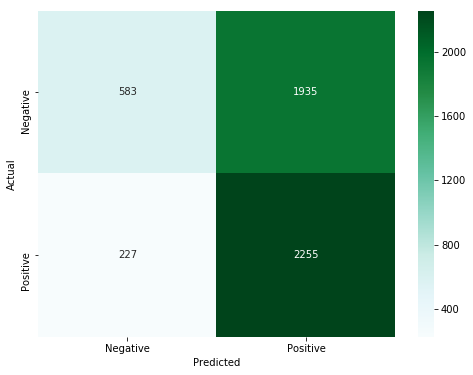

In [10]:
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_mat = confusion_matrix(y, prediction)
fig, ax = plt.subplots(figsize=(8,6))
classes=['Negative', 'Positive']
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=classes, yticklabels=classes, cmap=plt.cm.BuGn)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Deployment of model trained outside

In [8]:
from sagemaker.pytorch import PyTorchModel
profile.model_data = 's3://sagemaker-us-east-1-592068120969/pytorch-training-2020-05-17-15-33-13-034/model.tar.gz'
profile.container = PyTorchModel
Profile.set('TestDeploySMProfile', profile)

In [9]:
%py_deploy -n pytorch_model.py -s demo/scripts -p TestDeploySMProfile -pm $platform

-----------------------!

<IPython.core.display.JSON object>

In [10]:
#Use job_mldsl_test_1590576828_predictor instance to browse job properties.
predictor=job_tracker['mldsl_test_1590576828_predictor']

## PREDICTION

In [14]:
preds = predictor.predict(x_train[:, :150])
prediction = preds.argmax(axis=1)
y_train = np.load('demo/data/label_train.npy', allow_pickle=True)
n_samples=500
y = y_train[:].argmax(axis=1)
target_names = ['negative review', 'positive review']

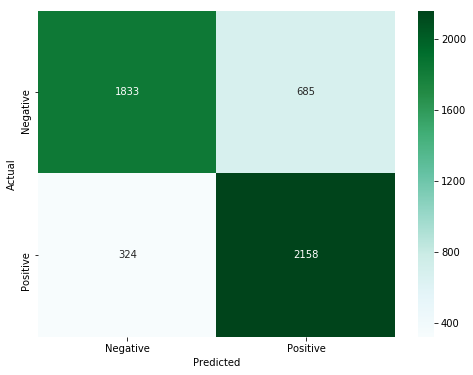

In [15]:
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_mat = confusion_matrix(y, prediction)
fig, ax = plt.subplots(figsize=(8,6))
classes=['Negative', 'Positive']
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=classes, yticklabels=classes, cmap=plt.cm.BuGn)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [16]:
print(classification_report(y, prediction,target_names=target_names))

                 precision    recall  f1-score   support

negative review       0.85      0.73      0.78      2518
positive review       0.76      0.87      0.81      2482

      micro avg       0.80      0.80      0.80      5000
      macro avg       0.80      0.80      0.80      5000
   weighted avg       0.80      0.80      0.80      5000

